In [1]:
import joblib
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
sns.set()

In [2]:
from Twitter.analysis_v2.data_prediction_ml import get_test_train_data
from Twitter.analysis_v2.data_prediction_ml import prepare_model_data
from Twitter.analysis_v2.data_prediction_ml import split_data
from Twitter.analysis_v2.data_prediction_ml import compare_base_models
from Twitter.analysis_v2.data_prediction_ml import find_best_params
from Twitter.analysis_v2.data_prediction_ml import train_evaluate_save

In [3]:
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import RFE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest

In [4]:
BASE_FOLDER = "../../data/processed_tweets/"

num_vars = ['followers', 'following', 'tweet_count', 'seniority']
cat_vars = ['topics', 'sentiment', 'hashtags', 'verified', 'day_phase', 'day_of_week', 'month']
cat_vars_enc = ['topics_ids', 'sentiment_enc', 'hashtags_enc', 'verified_enc', 'day_phase_enc', 'day_of_week_enc', 'month_enc']

variables_to_predict = ['followers', 'following', 'tweet_count', 'seniority', 'verified_enc', 'day_phase_enc', 'day_of_week_enc', 'month_enc', 'topics_ids', 'sentiment_enc', 'hashtags_enc']

In [5]:
train_df, test_df = get_test_train_data(False)

['tweets_2019.csv', 'tweets_2020.csv', 'tweets_2021.csv']


In [6]:
train_df = prepare_model_data(train_df)
test_df = prepare_model_data(test_df)

In [7]:
X_train, y_train, X_test, y_test = split_data(train_df, test_df)

(383207, 72)
(383207,)
(174108, 72)
(174108,)


In [8]:
def get_encoded_cols():
    encoded_cols = []
    for cat in cat_vars:
        content = [x for x in X_train.columns[X_train.columns.str.startswith(cat)].tolist() if (x not in cat_vars_enc) and (x not in cat_vars) and (x != 'topics_cleaned')]
        encoded_cols += content
    print(len(encoded_cols), "encoded cols found")
    return encoded_cols

In [9]:
cat_vars_encoded = get_encoded_cols()

38 encoded cols found


In [10]:
for cat in cat_vars_encoded:
    X_train[cat] = X_train[cat].fillna(0)

## Standardization

In [11]:
X_train_cats = X_train[cat_vars_encoded]
scaler = StandardScaler().fit(X_train[num_vars])
X_train_num_scaled = scaler.transform(X_train[num_vars])
X_train_num_scaled = pd.DataFrame(X_train_num_scaled, columns=X_train[num_vars].columns).set_index(X_train.index)

X_test_num_scaled = scaler.transform(X_test[num_vars])
X_test_num_scaled = pd.DataFrame(X_test_num_scaled, columns=X_test[num_vars].columns).set_index(X_test.index)

## Feature Selection

In [12]:
num_feat_to_keep = pd.DataFrame(index=X_train_cats.columns)
cat_feat_to_keep = pd.DataFrame(index=X_train_num_scaled.columns)

In [13]:
def add_feature_selection_res(df_res, features_to_keep, name):
    df_res[name] = 'Discard'
    for var in features_to_keep:
        df_res.loc[var, name] = 'Keep'

### Categorical variables selection

#### Chi-square

In [14]:
def chi_analysis(df_feat_to_keep, X_train, y_train):
    chi2_features = SelectKBest(chi2, k=20)
    chi2_features.fit_transform(X_train, y_train)
    features_to_keep = chi2_features.get_feature_names_out()
    print(features_to_keep)
    add_feature_selection_res(df_feat_to_keep, features_to_keep, 'Chi2')

In [15]:
chi_analysis(cat_feat_to_keep, X_train_cats, y_train)

['topics_cleaned_Entities' 'topics_cleaned_Interest and Hobbies'
 'topics_cleaned_Music' 'topics_cleaned_Person' 'topics_cleaned_Sport'
 'topics_cleaned_TV and Movies' 'topics_cleaned_News' 'sentiment_Neutral'
 'sentiment_Positive' 'hashtags_True' 'verified_True' 'day_phase_Dusk'
 'day_phase_Middle of the night' 'day_phase_Morning'
 'day_of_week_Saturday' 'day_of_week_Sunday' 'month_December'
 'month_February' 'month_March' 'month_November']


### Numerical variables selection

#### ANOVA

In [16]:
def anova_analysis(num_feat_to_keep, X_train, y_train):
    fvalue_selector = SelectKBest(f_classif, k=3)
    fvalue_selector.fit_transform(X_train, y_train)
    features_to_keep = X_train.columns[fvalue_selector.get_support(indices=True)].to_list()
    add_feature_selection_res(num_feat_to_keep, features_to_keep, 'ANOVA')

In [17]:
anova_analysis(num_feat_to_keep, X_train_num_scaled, y_train)

#### Tree-based

In [18]:
def tree_analysis(num_feat_to_keep, X_train, y_train):
    clf = ExtraTreesClassifier(n_estimators=50)
    clf = clf.fit(X_train, y_train)
    features_to_keep = pd.Series(clf.feature_importances_, index=X_train.columns).nlargest(3).index
    add_feature_selection_res(num_feat_to_keep, features_to_keep, 'Trees')

In [19]:
tree_analysis(num_feat_to_keep, X_train_num_scaled, y_train)

#### LASSO Regression

In [20]:
def lasso_analysis(num_feat_to_keep, X_train, y_train):
    reg = LassoCV()
    reg.fit(X_train, y_train)
    coef = pd.Series(abs(reg.coef_), index=X_train.columns)  #Check the coefficients associated with each of the variables
    features_to_keep = coef.nlargest(3).index
    add_feature_selection_res(num_feat_to_keep, features_to_keep, 'Lasso Regression')

In [21]:
lasso_analysis(num_feat_to_keep, X_train_num_scaled, y_train)

#### Recursive Feature Elimination

In [22]:
def rfe_analysis(num_feat_to_keep, X_train, y_train):
    rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=3)
    rfe.fit(X_train, y_train)
    features_to_keep = X_train.columns[rfe.support_]
    add_feature_selection_res(num_feat_to_keep, features_to_keep, 'RFE')

In [23]:
rfe_analysis(num_feat_to_keep, X_train_num_scaled, y_train)

### Final variables

In [24]:
num_feat_to_keep['Discard Nr'] = num_feat_to_keep.apply(lambda x: x.str.findall('Discard').str.len()).sum(axis = 1).astype(int)
num_feat_to_keep

,ANOVA,Trees,Lasso Regression,RFE,Discard Nr
topics_cleaned_Brand,Discard,Discard,Discard,Discard,4
topics_cleaned_Entities,Discard,Discard,Discard,Discard,4
topics_cleaned_Holiday,Discard,Discard,Discard,Discard,4
topics_cleaned_Interest and Hobbies,Discard,Discard,Discard,Discard,4
topics_cleaned_Music,Discard,Discard,Discard,Discard,4
topics_cleaned_Other,Discard,Discard,Discard,Discard,4
topics_cleaned_Person,Discard,Discard,Discard,Discard,4
topics_cleaned_Political,Discard,Discard,Discard,Discard,4
topics_cleaned_Sport,Discard,Discard,Discard,Discard,4
topics_cleaned_TV and Movies,Discard,Discard,Discard,Discard,4


In [25]:
cat_feat_to_keep['Discard Nr'] = cat_feat_to_keep.apply(lambda x: x.str.findall('Discard').str.len()).sum(axis = 1).astype(int)
cat_feat_to_keep

,Chi2,Discard Nr
followers,Discard,1
following,Discard,1
tweet_count,Discard,1
seniority,Discard,1
topics_cleaned_Entities,Keep,0
topics_cleaned_Interest and Hobbies,Keep,0
topics_cleaned_Music,Keep,0
topics_cleaned_Person,Keep,0
topics_cleaned_Sport,Keep,0
topics_cleaned_TV and Movies,Keep,0


In [26]:
cat_to_keep = cat_feat_to_keep[cat_feat_to_keep['Discard Nr'] < 1].index.tolist()
num_to_keep = num_feat_to_keep[num_feat_to_keep['Discard Nr'] < 3].index.to_list()
print(cat_to_keep + num_to_keep)

['topics_cleaned_Entities', 'topics_cleaned_Interest and Hobbies', 'topics_cleaned_Music', 'topics_cleaned_Person', 'topics_cleaned_Sport', 'topics_cleaned_TV and Movies', 'topics_cleaned_News', 'sentiment_Neutral', 'sentiment_Positive', 'hashtags_True', 'verified_True', 'day_phase_Dusk', 'day_phase_Middle of the night', 'day_phase_Morning', 'day_of_week_Saturday', 'day_of_week_Sunday', 'month_December', 'month_February', 'month_March', 'month_November', 'followers', 'following', 'seniority', 'tweet_count']


In [27]:
X_train = X_train[cat_to_keep].copy()
X_train[num_to_keep] = X_train_num_scaled[num_to_keep]

In [28]:
X_test = X_test[cat_to_keep].copy()
X_test[num_to_keep] = X_test_num_scaled[num_to_keep]

## Balacing the dataset

### SMOTE Method

In [29]:
print("Before over sampling: ", Counter(y_train))
over_sample = SMOTE(random_state=7)
X_train, y_train = over_sample.fit_resample(X_train, y_train)
print("After over sampling: ", Counter(y_train))

Before over sampling:  Counter({0: 322530, 1: 60677})
After over sampling:  Counter({1: 322530, 0: 322530})


## Models

In [30]:
def algorithm_comparison_chart(title, models_names, results):
    fig = plt.figure()
    fig.suptitle(title)
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(models_names)
    plt.figure(figsize=(16, 9))
    plt.show()

LR: 0.319465 (0.094866)
LDA: 0.285761 (0.084173)
CART: 0.670055 (0.058293)
NB: 0.537795 (0.242859)
AB: 0.509506 (0.046899)
GBM: 0.567002 (0.032666)
RFC: 0.744211 (0.041947)
ET: 0.781076 (0.039608)


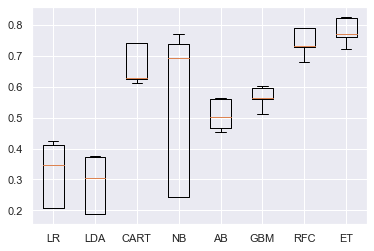

<Figure size 1152x648 with 0 Axes>

In [31]:
models = [('LR', LogisticRegression(solver='lbfgs')), ('LDA', LinearDiscriminantAnalysis()), ('CART', DecisionTreeClassifier()), ('NB', GaussianNB()),
          ('AB', AdaBoostClassifier()), ('GBM', GradientBoostingClassifier()), ('RFC', RandomForestClassifier(n_estimators=100)), ('ET', ExtraTreesClassifier())]
num_folds = 5
seed = 7
scoring = 'accuracy'
best_base_model, names, results = compare_base_models(models, X_train, y_train, scoring, num_folds)
algorithm_comparison_chart("", names, results)

In [32]:
names

['LR', 'LDA', 'CART', 'NB', 'AB', 'GBM', 'RFC', 'ET']

## Hyperparameter Optimization

In [ ]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12]
}
best_params = find_best_params(best_base_model[1], param_grid, X_train, y_train)
best_params

Fitting 5 folds for each of 72 candidates, totalling 360 fits


In [ ]:
optimized_model = ExtraTreesClassifier(bootstrap=best_params['bootstrap'], max_depth=best_params['max_depth'], max_features=best_params['max_features'],
                       min_samples_leaf=best_params['min_samples_leaf'], min_samples_split=best_params['min_samples_split'])
                       #best_params['n_estimators'])

## Test final model

In [ ]:
train_evaluate_save(optimized_model, X_train, y_train, X_test, y_test)

In [ ]:
popularity_model = joblib.load('../../data/models/popularity.joblib')
predictions = popularity_model.predict(X_test)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))